In [90]:
import boto3
from datetime import datetime, timedelta
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [91]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
save_path = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/20210101_f01_sfc.grib2"
ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})


Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [92]:
def get_temp_grid_centered(ds, half_size):   
    lats = ds['latitude'].values  # Shape: (1059, 1799)
    lons = ds['longitude'].values  # Shape: (1059, 1799)
    temp = ds['t'].values         # Shape: (1059, 1799)

    # KBMG coordinates
    target_lat = 39.14
    target_lon = -86.62

    # Check longitude convention and adjust if necessary
    print(f"Longitude range: {lons.min()} to {lons.max()}")
    if lons.min() >= 0 and lons.max() > 180:
        target_lon = 360 + target_lon if target_lon < 0 else target_lon
        print(f"Adjusted target_lon to {target_lon}")  # Should be 273.38

    # Find the closest grid point to KBMG
    lat_diff = np.abs(lats - target_lat)
    lon_diff = np.abs(lons - target_lon)
    comb_diff = lat_diff + lon_diff
    center_y, center_x = np.unravel_index(np.argmin(comb_diff), lats.shape)

    print(f"Center indices: y={center_y}, x={center_x}")
    print(f"Center coords: lat={lats[center_y, center_x]}, lon={lons[center_y, center_x]}")


    grid_size = 2 * half_size + 1  

    temp_grid = np.full((grid_size, grid_size), np.nan, dtype=temp.dtype)
    lat_grid = np.full((grid_size, grid_size), np.nan, dtype=lats.dtype)
    lon_grid = np.full((grid_size, grid_size), np.nan, dtype=lons.dtype)

    for i in range(grid_size):
        for j in range(grid_size):
            dataset_y = center_y - half_size + i
            dataset_x = center_x - half_size + j
            if 0 <= dataset_y < lats.shape[0] and 0 <= dataset_x < lons.shape[1]:
                temp_grid[i, j] = temp[dataset_y, dataset_x]
                lat_grid[i, j] = lats[dataset_y, dataset_x]
                lon_grid[i, j] = lons[dataset_y, dataset_x]
    return temp_grid, lat_grid, lon_grid

# Print the result
temp_grid, lat_grid, lon_grid = get_temp_grid_centered(ds, 3)
print("Temperature Grid:")
print(temp_grid)
print("KBMG temp")
print(temp_grid[3, 3])


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Temperature Grid:
[[272.25784 272.32034 272.38284 272.38284 272.50784 272.50784 272.57034]
 [272.32034 272.32034 272.32034 272.38284 272.50784 272.57034 272.44534]
 [272.38284 272.32034 272.25784 272.25784 272.44534 272.50784 272.50784]
 [272.38284 272.44534 272.38284 272.50784 272.25784 272.44534 272.50784]
 [272.38284 272.32034 272.32034 272.38284 272.38284 272.50784 272.44534]
 [272.32034 272.25784 271.94534 272.50784 272.25784 272.44534 272.44534]
 [272.07034 272.07034 271.94534 272.19534 272.19534 272.38284 272.38284]]
KBMG temp
272.50784


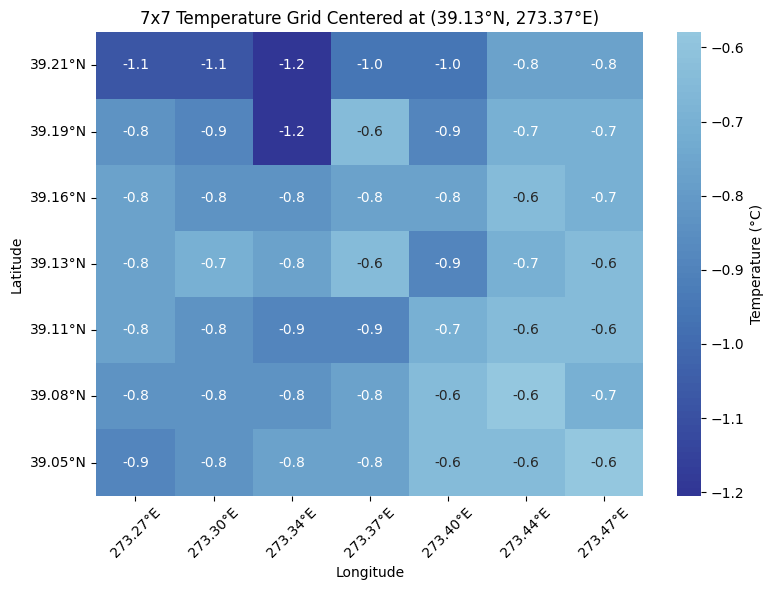

In [93]:
# Calculate n from the grid shape (assuming square grid)
n = temp_grid.shape[0]
half_size = (n - 1) // 2  # Center index, integer for odd n

# Convert temperatures to Celsius (optional, adjust based on your data)
temp_grid_celsius = temp_grid - 273.15

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_grid_celsius,
            annot=True,          # Show temperature values in each cell
            fmt='.1f',           # Format to 1 decimal place
            cmap='RdYlBu_r',     # Red (hot) to blue (cold), reversed
            cbar_kws={'label': 'Temperature (°C)'},  # Colorbar label
            center=0)            # Center colormap at 0°C

# Extract center coordinates for the title
center_lat = lat_grid[half_size, half_size]
center_lon = lon_grid[half_size, half_size]

# Generate axis labels from the center column (lat) and center row (lon)
lat_labels = [f"{lat:.2f}°N" for lat in lat_grid[:, half_size]]
lon_labels = [f"{abs(lon):.2f}°{'W' if lon < 0 else 'E'}" for lon in lon_grid[half_size, :]]

# Set ticks and labels
plt.xticks(np.arange(n) + 0.5, lon_labels, rotation=45)
plt.yticks(np.arange(n) + 0.5, lat_labels, rotation=0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{n}x{n} Temperature Grid Centered at ({center_lat:.2f}°N, {abs(center_lon):.2f}°{'W' if center_lon < 0 else 'E'})")

plt.gca().invert_yaxis()
# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [96]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
inp_dataset = []
for i in range(0,25):
    if i < 10:
        save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/20210101_f0{i}_sfc.grib2"
        ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
        inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
    else:
        save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/20210101_f{i}_sfc.grib2"
        ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
        inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
inp_dataset

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


[array([[272.25784, 272.32034, 272.38284, 272.38284, 272.50784, 272.50784,
         272.57034],
        [272.32034, 272.32034, 272.32034, 272.38284, 272.50784, 272.57034,
         272.44534],
        [272.38284, 272.32034, 272.25784, 272.25784, 272.44534, 272.50784,
         272.50784],
        [272.38284, 272.44534, 272.38284, 272.50784, 272.25784, 272.44534,
         272.50784],
        [272.38284, 272.32034, 272.32034, 272.38284, 272.38284, 272.50784,
         272.44534],
        [272.32034, 272.25784, 271.94534, 272.50784, 272.25784, 272.44534,
         272.44534],
        [272.07034, 272.07034, 271.94534, 272.19534, 272.19534, 272.38284,
         272.38284]], dtype=float32),
 array([[272.25784, 272.32034, 272.38284, 272.38284, 272.50784, 272.50784,
         272.57034],
        [272.32034, 272.32034, 272.32034, 272.38284, 272.50784, 272.57034,
         272.44534],
        [272.38284, 272.32034, 272.25784, 272.25784, 272.44534, 272.50784,
         272.50784],
        [272.38284, 272

TODO, Create script that iterates through every 1 hour model run of the HRRR and exctracts the temp_data grid surrounding it. Also correlate that with timesteps of KBMG